##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Aligned Feature Visualization Interpolation


![](https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-interpolation-header.png =802x)

This notebook uses [**Lucid**](https://github.com/tensorflow/lucid) to create a visualizations that interpolates between two feature visualizations. On the way, it introduces custom parameterizations in lucid, which we will use here to build a shared parameterization that encourages alignment of visual landmarks between visualizations.

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is [as a colab notebook](https://colab.research.google.com/drive/1XuxLjIZj9MV-lRCpXHBhLo5A41Zs0f8E), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**


## Install, Import, Load Model

In [ ]:
!pip install --quiet "lucid>=0.3.11"
#!pip install --quiet --upgrade-strategy=only-if-needed git+https://github.com/tensorflow/lucid.git

In [3]:
# Imports

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import lucid.modelzoo.vision_models as models
from lucid.misc.io import load, save, show

import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render

In [4]:
# Let's import a model from the Lucid modelzoo!

model = models.InceptionV1()
model.load_graphdef()

## Creating an Interpolation

First, let's take a look at the two neurons we want to interpolate between. This code should feel familiar from the Lucid tutorial:

In [5]:
neuron1 = ("mixed4a_pre_relu", 476)
neuron2 = ("mixed4a_pre_relu", 460)

Many objective methods in lucid will take a `string` layer name and an `int` channel. 
I like to save them as tuples and use the destructuring operator (`*`) to conveniently pass them as arguments:

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x13ed7d040>
512 1110.9586



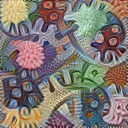

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x13ed7d7c0>
512 1697.1307



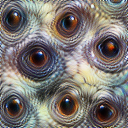

In [6]:
# For each neuron, we create a simple input parameterization, an objective, 
# and render a visualization:

for neuron in [neuron1, neuron2]:
    param_f = lambda: param.image(128)
    objective = objectives.channel(*neuron)
    _ = render.render_vis(model, objective, param_f)

*You may wonder why these look a little less saturated than the images at the header of this notebook.
The images in the header have simply been optimized for longer. If you need to recreate that look, you can set `thresholds=[2560]` on all `render_vis` calls. That will make working with this notebook a little slow, so we'll use the default thresholds for now.*

When I know I'll deal with more than one neuron, I sometimes want to optimize them at the same time, rather than having to call `render_vis` twice.
Currently I had to run it twice because `param.image(128, ...)` will give us a parameterization of shape `(1, 128, 128, 3)`--a tensor with a batch size of 1, or a single image. So, if I want to optimize two images at the same time, I will need to create a parameterization that can hold two images.

To do so, I can use the `batch` parameter on many of the built-in objectives and parameterizations of lucid. I tell the parameterization to procide two image by supplying `batch=2` in the `param.image` call. I then explicitly set `batch=0` and `batch=1` on the two neuron objectives.

This creates a single parameterization with a batch dimension of 2. Its shape will be `(2, 128, 128, 3)`. During rendering, [`render_viz` will call `np.hstack ` on this tensor](https://github.com/tensorflow/lucid/blob/master/lucid/optvis/render.py#L98), so it can be displayed as one wide image:

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x13ed4ef10>
512 3264.582



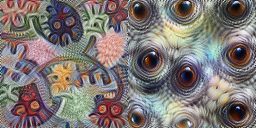

In [10]:
param_f = lambda: param.image(128, batch=2)
objective = objectives.channel(*neuron1, batch=0) + objectives.channel(*neuron2, batch=1)
_ = render.render_vis(model, objective, param_f)

Now that we've seen parameterizations with multiple images, you can already see how we will get to the interpolation--we will just add more images to the batch dimension, and for each of them will use a linear combination of the two neuron objectives! Conceptually, it will look something like this:

![](https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-interpolation-two-to-five.png =800x)

That is going to be a lot of objectives! Let's give it a try:

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x1409fcaf0>
512 6711.043



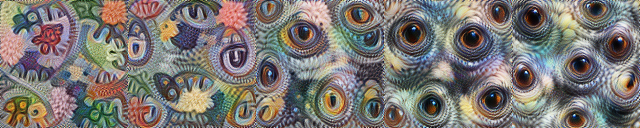

In [11]:
param_f = lambda: param.image(128, batch=5)
objective = objectives.Objective.sum([
    # neuron 1 objectives, orange row:
    1.00 * objectives.channel(*neuron1, batch=0),
    0.75 * objectives.channel(*neuron1, batch=1),
    0.50 * objectives.channel(*neuron1, batch=2),
    0.25 * objectives.channel(*neuron1, batch=3),
    0.00 * objectives.channel(*neuron1, batch=4),
    # neuron 2 objectives, green row:
    0.00 * objectives.channel(*neuron2, batch=0),
    0.25 * objectives.channel(*neuron2, batch=1),
    0.50 * objectives.channel(*neuron2, batch=2),
    0.75 * objectives.channel(*neuron2, batch=3),
    1.00 * objectives.channel(*neuron2, batch=4),
])
_ = render.render_vis(model, objective, param_f)

Nice! You can already see some interesting interactions between these neurons. For example, in the second image take a look at how the art-pattern starts to include round ovals.

To make specifying objectives like this easier, Lucid has [a built in objective](https://github.com/tensorflow/lucid/blob/master/lucid/optvis/objectives.py#L282) called `channel_interpolate`. Now that you've seen how we built this from scratch, I encourage you to take a look at the code! **When you understand the underlying primitives, there's surprisingly little magic going on in Lucid.**

So here's a more terse version of the above. (It's also running for twice as many steps.):

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x140bb3070>
1024 5856.284



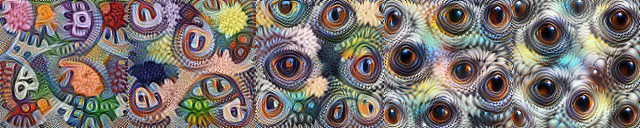

In [ ]:
objective = objectives.channel_interpolate(*neuron1, *neuron2)
param_f = lambda: param.image(128, batch=5)
_ = render.render_vis(model, objective, param_f=param_f, thresholds=[1024])

## Introducing Alignment

The interpolation in the last segment already helps understand how neurons interact, but visuakl landmarks such as eyes change position from one frame to the next. 
This lack of alignment can make it harder to see the difference due to slightly different objectives, because they’re swamped by the much larger differences in layout.

We can see the issue with independent optimization if we look at the interpolated frames as an animation:

In [ ]:
%%html
<style> 
  #animation {
    width: 128px;
    height: 128px;
    background: url('https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-interpolation-example-run.png') left center;
    animation: play 1.5s steps(5) infinite alternate;
  }
  @keyframes play {
    100% { background-position: -640px; }
  }
</style><div id='animation'></div>
# You can use `Clear Output` if the animation gets annoying.

Since each image was optimized independently, it should not surprise us too much that they don't look similar!

In fact, this will happen even if we optimize for the same objective every time. Since we create these visualizations from random noise, every random initialization will look slightly different:

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x141007df0>



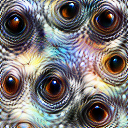
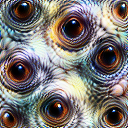
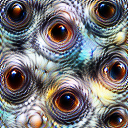
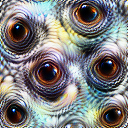
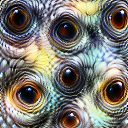

In [19]:
objective = sum([objectives.channel(*neuron2, batch=i) for i in range(5)])
param_f = lambda: param.image(128, batch=5, sd=0.5) # setting sd to .5 increases the noise used to initialize the image parameterization
images = render.render_vis(model, objective, param_f=param_f, thresholds=[1024], verbose=False)[-1]
show(images)

There are many plausible ways to go about making these images more aligned. For example, we could use additional objectives that penalizes the difference between neighboring images. In this notebook, however, we want to introduce a different technique that will turn out quite elegant: **a shared parameterization**.


### Parameterizations
We first need to take a deeper look at `lucid.optvis.param`'s child modules. So far we always used a convenience method called `image` from the creatively named `images` module. Under the hood, `image` assembles a parameterization from primitives found in the first two of the following modules. Let's import them now:

In [6]:
from lucid.optvis.param import spatial, color, lowres

As a reminder, this is the parameterization we used so far:

```python
param.image(128, batch=5)
```

[Taking a peek at the source code](), this assembles roughly the following pieces:

In [7]:
def default_image_param_f(batch = 1, size = 128, channels = 3):
    shape = (batch, size, size, channels)
    fft_parameterization = spatial.fft_image(shape)
    rgb_parameterization = color.to_valid_rgb(fft_parameterization, decorrelate=True)
    return rgb_parameterization

Let's just quickly sanity check that this still works:

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x1410c9e20>
512 1062.1003



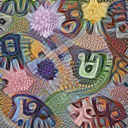

In [22]:
objective = objectives.channel(*neuron1)
_ = render.render_vis(model, objective, default_image_param_f)

…looks like it does! So now that we can assemble custom parameterizations, let's look at how to use this skill to achieve better alignment between our interpolated neurons.

### Introducing `lowres_tensor`

What we mean by shared parameterization is that a part of the image parameterization will be shared between all images, and another part will be unique to each of them:

![lowres_tensor](https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-interpolation-lowres-tensor-1.png =489x)

`lowres_tensor` takes two shapes as arguments, and creates a per-dimension bilinear interpolation between those shapes. Let's break this down in a simple case:

Let's say we have an image parameterization like before, with a shape of (5, 128, 128, 3). Then we could ask for a `lowres_tensor` of shape (**1**, 128, 128, 3) to get a shared parameterization, like this:

In [8]:
def simple_shared_param_f():
    shared = lowres.lowres_tensor((6, 128, 128, 3), (1, 128, 128, 3))
    return color.to_valid_rgb(shared, decorrelate=True)

If we used this in our `channel_interpolate` objective, what would we expect to see?

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x140914f10>
512 5715.1387



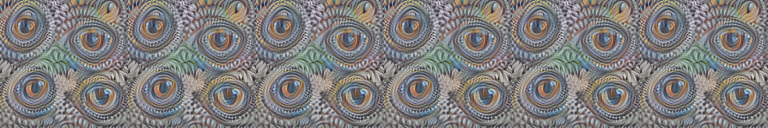

In [24]:
objective = objectives.channel_interpolate(*neuron1, *neuron2)
_ = render.render_vis(model, objective, param_f=simple_shared_param_f)

So even though our *objective* here is interpolating between two neurons, our parameterization is *entirely shared*, so all images end up looking the same.

At first glance this may seem entirely undesireable. However it turns out that this is very helpful for creating a *part* of our final parameterization: the part that will be shared between all images and cause the interpolation to align better.

To get closer to our goal, consider that `lowres_tensor` can interpolate along any dimension, not just batch. For example, it can interpolate between spatial dimensions:

![lowres_tensor_2](https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-interpolation-lowres-tensor-2.png =489x)

Let's take a look at what optimization result such a parameterization results in, too:


In [9]:
def lowres_param_f():
    shared = lowres.lowres_tensor((6, 128, 128, 3), (1, 128//16, 128//16, 3))
    return color.to_valid_rgb(shared, decorrelate=True)

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x140914f70>
512 420.20764



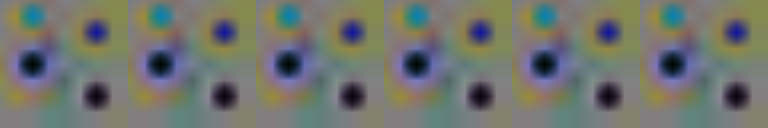

In [26]:
objective = objectives.channel_interpolate(*neuron1, *neuron2)
_ = render.render_vis(model, objective, param_f=lowres_param_f)

We can also combine interpolation between batch and spatial dimensions:

In [10]:
def lowres_interpolate_param_f():
    shared = lowres.lowres_tensor((6, 128, 128, 3), (2, 128//16, 128//16, 3))
    return color.to_valid_rgb(shared, decorrelate=True)

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x145497670>
512 608.65857



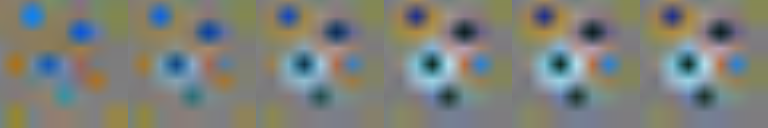

In [17]:
objective = objectives.channel_interpolate(*neuron1, *neuron2)
_ = render.render_vis(model, objective, param_f=lowres_interpolate_param_f)

## Final Parameterization

Let's combine multiple of these shared representations with one that allows each image to be unique, like showjn in [Figure 3 of Differentiable Image Parameterizations](https://distill.pub/2018/differentiable-parameterizations/#figure-aligned-interpolation-examples):

![](https://storage.googleapis.com/tensorflow-lucid/notebooks/aligned-interpolation/header.png =713x)

In [11]:
def interpolate_f():
    unique = spatial.fft_image((6, 128, 128, 3))
    shared = [
        lowres.lowres_tensor((6, 128, 128, 3), (1, 128//2, 128//2, 3)),
        lowres.lowres_tensor((6, 128, 128, 3), (1, 128//4, 128//4, 3)),
        lowres.lowres_tensor((6, 128, 128, 3), (1, 128//8, 128//8, 3)),
        lowres.lowres_tensor((6, 128, 128, 3), (2, 128//8, 128//8, 3)),
        lowres.lowres_tensor((6, 128, 128, 3), (1, 128//16, 128//16, 3)),
        lowres.lowres_tensor((6, 128, 128, 3), (2, 128//16, 128//16, 3)),
    ]
    return color.to_valid_rgb(unique + sum(shared), decorrelate=True)

In [12]:
objective = objectives.channel_interpolate(*neuron1, *neuron2)
images = render.render_vis(model, objective, param_f=interpolate_f, verbose=False)

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x13ec6d8e0>


Sometimes it can be helpful to show the results as individual images to better see where each frame ends, and how well these images already align.

`render_viz` returns a list of optimization results whenever the step number is equal to a `threshold`. If you don't explicitly specify them, there's only one threshold. Let's get the last optimization results and use `show` to display them as a list of images. 

(`lucid.misc.io.show` inspects a tensor's shape interprets certain rank 4 tensors as batches of images automatically:)


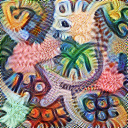
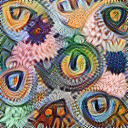
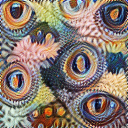
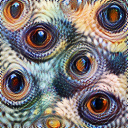
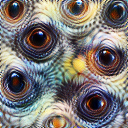
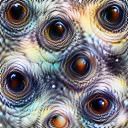

In [14]:
result = images[-1]
show(result)

Note how for example the yellow swirl in the top left corner changes and transitions to an eye!

(If you have re-run that cell this description may not be exact anymore, but you should see similarly well-aligned feature visualizations.)

We can play this one as an animation again. The result is still not perfectly aligned, but much better than what we started with.

In [15]:
def get_animation(images, interval=500):
    # video: np array with shape (frames, height, width, channels)
    fig = plt.figure(figsize=(2, 2), dpi=75, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = plt.imshow(images[0,:,:,:], aspect='auto')
    
    plt.close() # this is required to not display the generated image

    def init_fn():
        im.set_data(images[0,:,:,:])
    def animate_fn(i):
        im.set_data(images[i,:,:,:])
        return im
    return animation.FuncAnimation(fig, animate_fn, init_func=init_fn, frames=images.shape[0], interval=interval)

In [16]:
# You can use `Clear Output` if the animation gets annoying.
HTML(get_animation(result, interval=1500).to_html5_video())
#HTML(get_animation(result, interval=1500).to_jshtml(default_mode='reflect'))

In [ ]:
%%html
<style> 
  #animation {
    width: 128px;
    height: 128px;
    background: url('https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-interpolation-example-run-2.png') left center;
    animation: play 1.5s steps(6) infinite alternate;
  }
  @keyframes play {
    100% { background-position: -768px; }
  }
</style><div id='animation'></div>
# You can use `Clear Output` if the animation gets annoying.

To get the last step to appear even smoother, we can even add an additional alignment objective that encourages the activations of layers to be similar when images are close together in the batch dimension. At that point we're not strictly optimizing for the same objective anymore (because neighbors in the batch dimension will influence each other), so take this as a mostly aesthetic experiment.

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x13f7eb7c0>
32 3842.9863



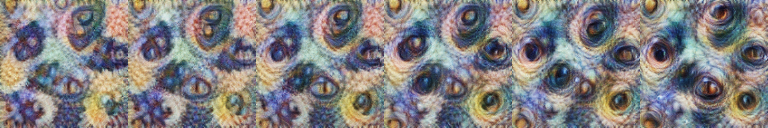

64 4564.213



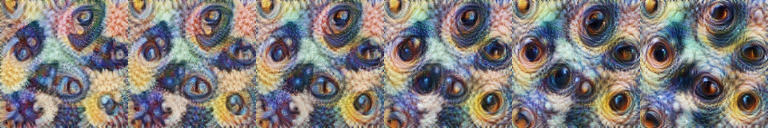

256 5577.275



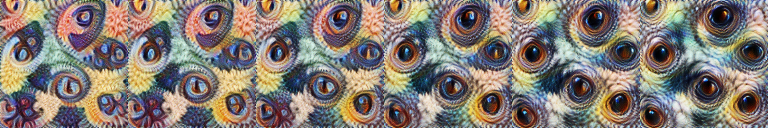

512 7209.6846



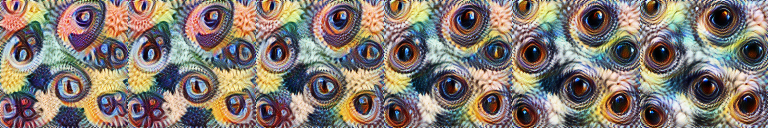

1024 7972.763



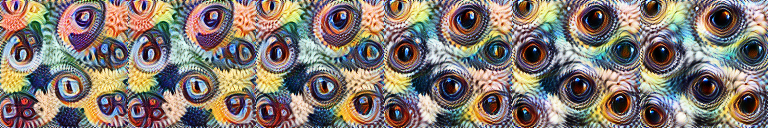

In [17]:
interpolation_objective = objectives.channel_interpolate(*neuron1, *neuron2)
alignment_objective = objectives.alignment('mixed3b', decay_ratio=5) + objectives.alignment('mixed4a', decay_ratio=5)
objective = interpolation_objective + 1e-1 * alignment_objective

images = render.render_vis(model, objective, param_f=interpolate_f, verbose=True, thresholds=(32,64,256,512, 1024))

In [25]:
# You can use `Clear Output` if the animation gets annoying.
HTML(get_animation(images[-1], interval=1500).to_html5_video())
#HTML(get_animation(images[-1], interval=1500).to_jshtml(default_mode='reflect'))

In [ ]:
%%html
<style> 
  #animation {
    width: 128px;
    height: 128px;
    background: url('https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-interpolation-example-run-4.png') left center;
    animation: play 1.5s steps(6) infinite alternate;
  }
  @keyframes play {
    100% { background-position: -768px; }
  }
</style><div id='animation'></div>
# You can use `Clear Output` if the animation gets annoying.